# Importing necessary libraries

In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score

from scipy.stats import zscore


In [2]:
df = pd.read_csv("cars-dataset.csv")  
df.shape

(398, 8)

## 1. EDA & Pre-processing (Make sure to remove all non-numeric entries from numeric columns) – 2.5 points

In [3]:
df.head()

,car name,cyl,disp,hp,wt,acc,yr,mpg
0,chevrolet chevelle malibu,8,307.0,130,3504,12.0,70,18.0
1,buick skylark 320,8,350.0,165,3693,11.5,70,15.0
2,plymouth satellite,8,318.0,150,3436,11.0,70,18.0
3,amc rebel sst,8,304.0,150,3433,12.0,70,16.0
4,ford torino,8,302.0,140,3449,10.5,70,17.0


In [4]:
df.isna().sum()

car name    0
cyl         0
disp        0
hp          0
wt          0
acc         0
yr          0
mpg         0
dtype: int64

No Missing values

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cyl,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
disp,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
wt,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acc,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
yr,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6


In [6]:
df.dtypes   

car name     object
cyl           int64
disp        float64
hp           object
wt            int64
acc         float64
yr            int64
mpg         float64
dtype: object

Since in the data types above it is clear that "HP" is object lets have a look into it

In [7]:
error_entry = pd.DataFrame(df.hp.str.isdigit()) 

error_entry[error_entry['hp'] == False]

,hp
32,False
126,False
330,False
336,False
354,False
374,False


In [8]:
df.loc[[32, 126, 330,336,354,374], :'hp']


,car name,cyl,disp,hp
32,ford pinto,4,98.0,?
126,ford maverick,6,200.0,?
330,renault lecar deluxe,4,85.0,?
336,ford mustang cobra,4,140.0,?
354,renault 18i,4,100.0,?
374,amc concord dl,4,151.0,?


In [9]:
#Replacing the '?' character with nan and converting the hp column into float
df = df.replace('?', np.nan)
df['hp'] = df['hp'].astype('float64')

In [10]:
#filling the nan values with the median value of the column
df=df.fillna(df['hp'].median())

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
car name    398 non-null object
cyl         398 non-null int64
disp        398 non-null float64
hp          398 non-null float64
wt          398 non-null int64
acc         398 non-null float64
yr          398 non-null int64
mpg         398 non-null float64
dtypes: float64(4), int64(3), object(1)
memory usage: 25.0+ KB


# 2.Use pair plot or scatter matrix to visualize how the different variables are related (Hint: The amount of Gaussian curves in the plot should give a visual identification of different clusters existing in the dataset) – 5 points


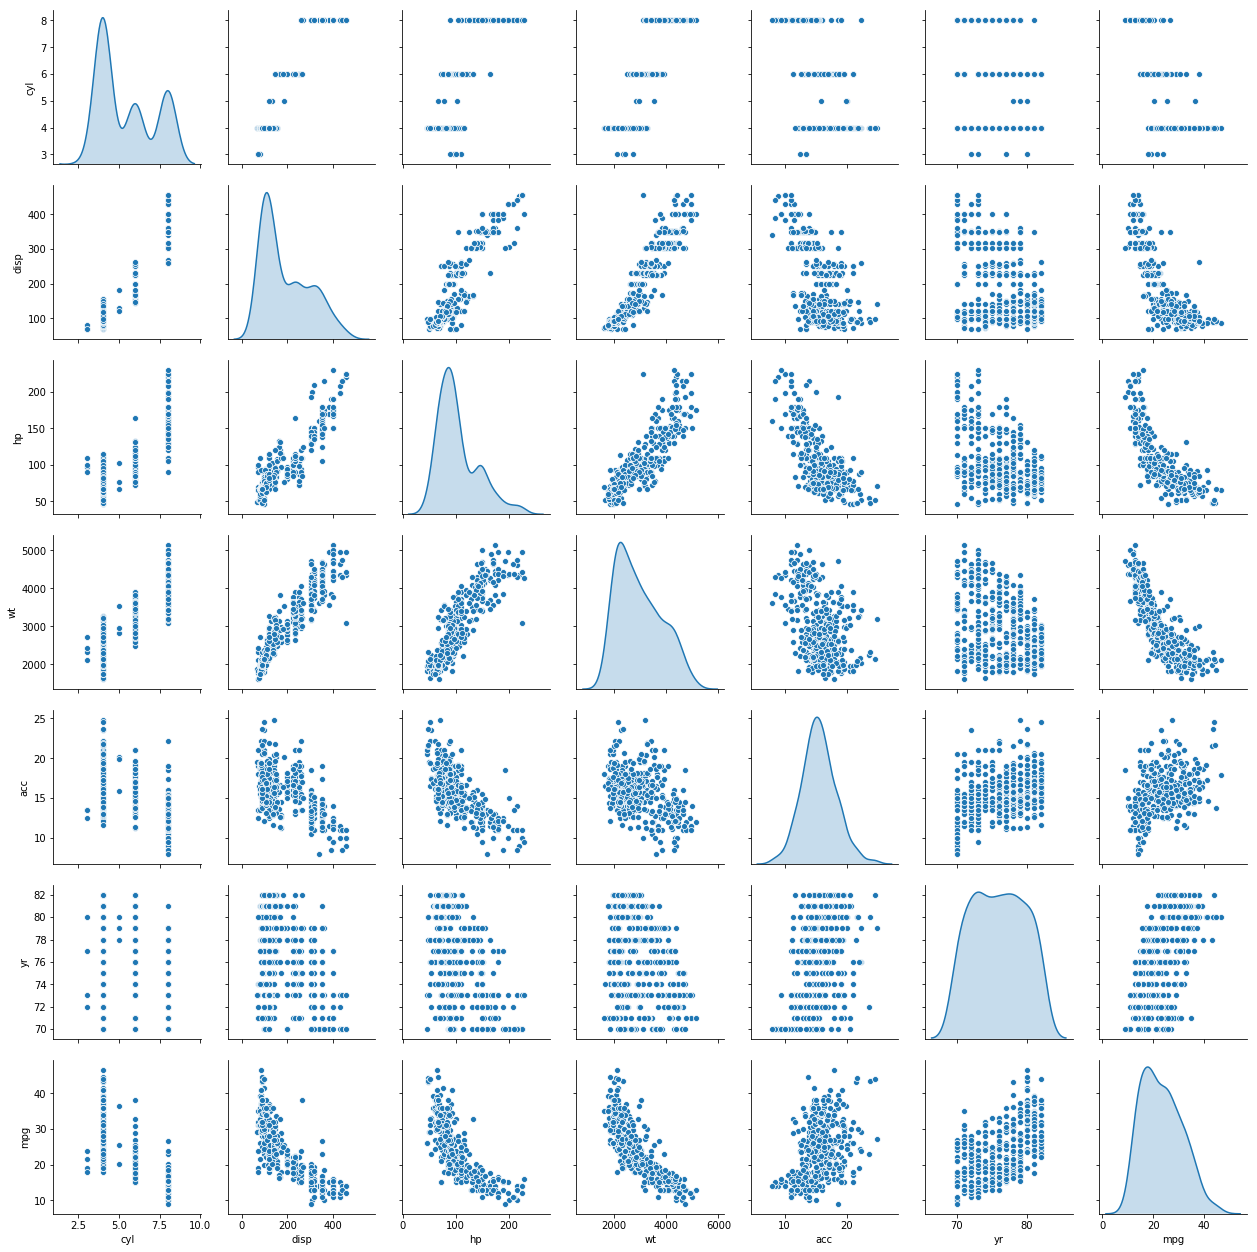

In [12]:
sns.pairplot(df, diag_kind='kde')   # plotting density curve to analyse how many clusters are possible \

From the above pairplot looking at the density curve,we are likely able to find  3 clusters 

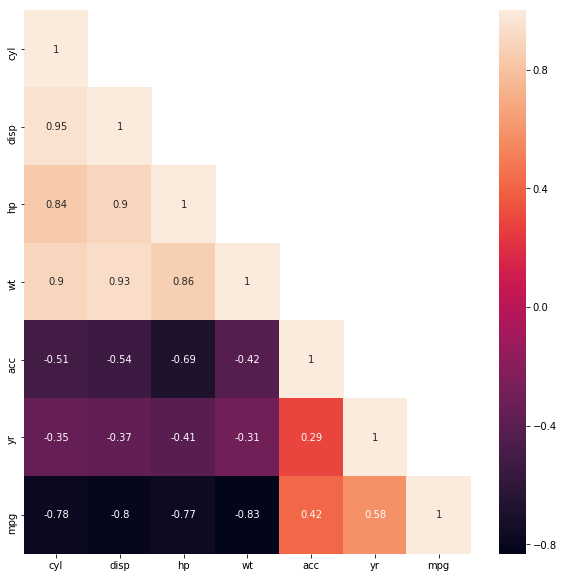

In [13]:
plt.figure(figsize=(10,10))
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True
sns.heatmap(corr,mask= mask,annot = True)

From the above heatmap it is clear that cyl,disp,hp and wt columns have positive co-relations with eachother

 Normalizing the data

In [14]:
df1=df.drop('car name',axis=1)
df=df1.drop('yr',axis=1)
df_z=df.apply(zscore)
df_z.head(10)

,cyl,disp,hp,wt,acc,mpg
0,1.498191,1.090604,0.673118,0.630870,-1.295498,-0.706439
1,1.498191,1.503514,1.589958,0.854333,-1.477038,-1.090751
2,1.498191,1.196232,1.197027,0.550470,-1.658577,-0.706439
3,1.498191,1.061796,1.197027,0.546923,-1.295498,-0.962647
4,1.498191,1.042591,0.935072,0.565841,-1.840117,-0.834543
5,1.498191,2.262118,2.454408,1.620492,-2.021656,-1.090751
6,1.498191,2.502182,3.030708,1.635863,-2.384735,-1.218855
7,1.498191,2.367746,2.899730,1.586204,-2.566274,-1.218855
8,1.498191,2.511784,3.161685,1.719809,-2.021656,-1.218855
9,1.498191,1.887617,2.244844,1.039961,-2.566274,-1.090751


## 3. Use K Means or Hierarchical clustering to find out the optimal no of clusters in the data. Identify and separate the clusters (15 points)


## From the visualization ,we could see some 3 to 4 good clusters,identifying and separating them


In [15]:
cluster_range = range( 2, 8)   # expect 3 to four clusters from the pair panel visual inspection hence restricting from 2 to 10
cluster_errors = []
for num_clusters in cluster_range:
    clusters = KMeans( num_clusters, n_init = 5)
    clusters.fit(df)
    labels = clusters.labels_
    centroids = clusters.cluster_centers_
    cluster_errors.append( clusters.inertia_ )
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } ) 
clusters_df[0:15]

,num_clusters,cluster_errors
0,2,7.428438e+07
1,3,3.420304e+07
2,4,1.904675e+07
3,5,1.376415e+07
4,6,1.034238e+07
5,7,7.784759e+06


# Elbow plot

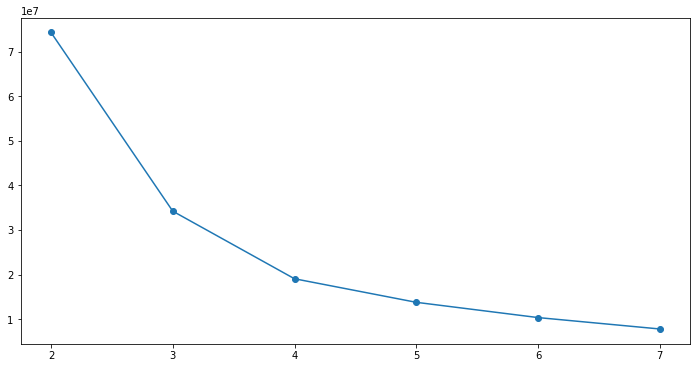

In [16]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

## The elbow plot confirms analysis that there are likely 3 or 4 good clusters.

 Let us start with 3 clusters

In [17]:
cluster = KMeans( n_clusters = 3, random_state = 7 )
cluster.fit(df_z)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=7, tol=0.0001, verbose=0)

In [18]:
centroids = cluster.cluster_centers_
centroids

array([[-0.85347696, -0.80321374, -0.67506194, -0.78549879,  0.36133415,
         0.75394661],
       [ 1.4860546 ,  1.48450715,  1.50624078,  1.38753374, -1.06267868,
        -1.15110476],
       [ 0.34598334,  0.23689416, -0.06773972,  0.29795187,  0.30089004,
        -0.47244453]])

In [19]:
centroid_df = pd.DataFrame(centroids, columns = list(df_z) )
centroid_df

,cyl,disp,hp,wt,acc,mpg
0,-0.853477,-0.803214,-0.675062,-0.785499,0.361334,0.753947
1,1.486055,1.484507,1.506241,1.387534,-1.062679,-1.151105
2,0.345983,0.236894,-0.067740,0.297952,0.300890,-0.472445


## The centroid of all the attributes are stored in the centroid_df

In [20]:
prediction=cluster.predict(df_z)
df_z["GROUP"] = prediction     # Creating a new column "GROUP" which will hold the cluster id of each record

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a240174a8>,
      dtype=object)

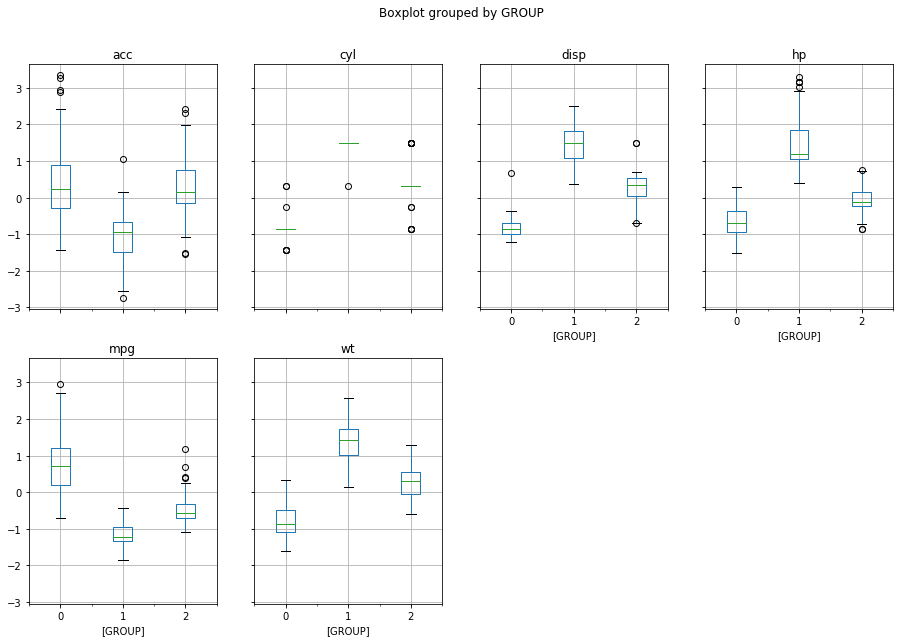

In [21]:
df_z.boxplot(by = 'GROUP',  layout=(2,4), figsize=(15, 10))


In [22]:
# dealing with outliers

data = df_z
       
def replace(group):
    median, std = group.median(), group.std()  
    outliers = (group - median).abs() > 2*std 
    group[outliers] = group.median()
    return group

data_corrected = (data.groupby('GROUP').transform(replace)) 
concat_data = data_corrected.join(pd.DataFrame(df_z['GROUP']))


/Users/bharath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2472ff98>,
      dtype=object)

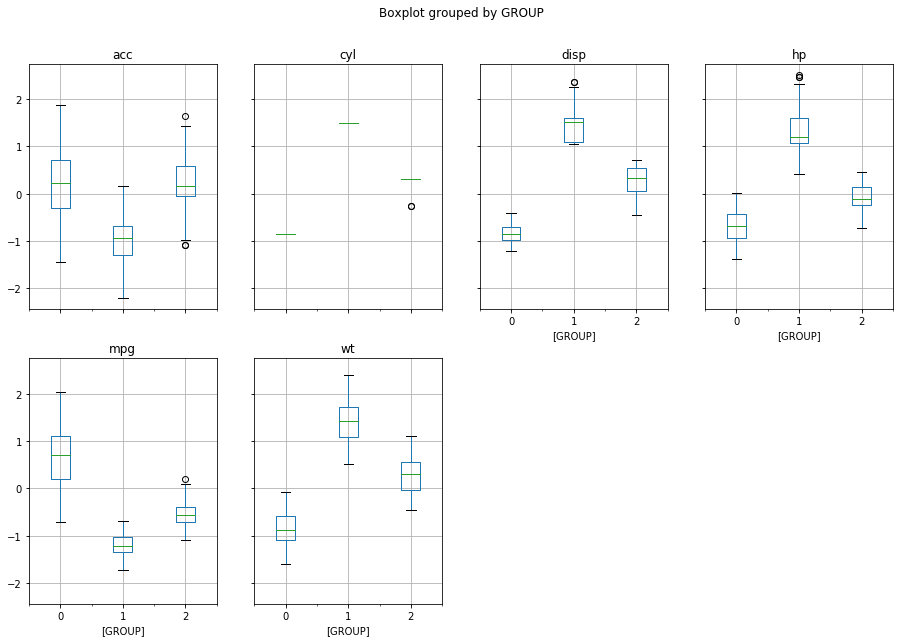

In [23]:
concat_data.boxplot(by = 'GROUP', layout=(2,4), figsize=(15, 10))

# 4. Use linear regression model on different clusters separately and print the coefficients of the models individually (7.5 points)


In [24]:
# Grouping each cluster data into a different dataframe to apply linear regression model separately

df_z_1cluster = df_z[df_z.GROUP == 0]
print("number of rows in first cluster",df_z_1cluster.shape)

df_z_2cluster = df_z[df_z['GROUP'] == 1]
print("number of rows in second cluster",df_z_2cluster.shape)

df_z_3cluster = df_z[df_z['GROUP'] == 2]
print("number of rows in third cluster",df_z_3cluster.shape)

number of rows in first cluster (207, 7)
number of rows in second cluster (97, 7)
number of rows in third cluster (94, 7)


In [25]:
def function(data):
    X = data.drop(['mpg','GROUP'], axis=1)
    y = data[['mpg']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=7)
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    for idx, col_name in enumerate(X_train.columns):
        print("The coefficient for {} is {}".format(col_name, model.coef_[0][idx]))
        
    # Let us check the intercept for the model
    y_predicted = model.predict(X_test)
    print("Mean squared error: ", mean_squared_error(y_test, y_predicted))
    print("R²:", r2_score(y_test, y_predicted))
    print("The intercept for our model is :",model.intercept_[0])    

    print("model score is:",model.score(X_test, y_test))
    
    return None


## Cluster 1:

In [26]:
function(df_z_1cluster)


The coefficient for cyl is 1.6736567089150427
The coefficient for disp is -0.49149098762073623
The coefficient for hp is -0.8725489476873093
The coefficient for wt is -0.10873094061885263
The coefficient for acc is -0.0884009716148337
Mean squared error:  0.3256061383070732
R²: 0.35918629750150344
The intercept for our model is : 1.1562095143827542
model score is: 0.35918629750150344


## Cluster 2:

In [27]:
function(df_z_2cluster)

The coefficient for cyl is -0.3442515289290879
The coefficient for disp is 0.06817685189430972
The coefficient for hp is -0.20412768266721
The coefficient for wt is -0.13689476673686382
The coefficient for acc is -0.11447799301183455
Mean squared error:  0.054843168101917535
R²: 0.38652670916091336
The intercept for our model is : -0.34773415340658786
model score is: 0.38652670916091336


## Cluster 3:

In [28]:
function(df_z_3cluster)


The coefficient for cyl is 0.33757686092937583
The coefficient for disp is -0.19818016819293183
The coefficient for hp is 0.06021555006007744
The coefficient for wt is -0.3054283707918234
The coefficient for acc is -0.03114933321146855
Mean squared error:  0.060092733323337304
R²: 0.45076779542745804
The intercept for our model is : -0.434103682646209
model score is: 0.45076779542745804


Using the dataframe without clusters and printing coefficients 

In [29]:
function(df_z)

The coefficient for cyl is -0.18062662251139666
The coefficient for disp is -0.006353705706338796
The coefficient for hp is -0.15736835807521213
The coefficient for wt is -0.5455657997010585
The coefficient for acc is -0.031227174223416723
Mean squared error:  0.32232776921776274
R²: 0.6404659395890375
The intercept for our model is : 0.008890302903660802
model score is: 0.6404659395890375


# Cluster Plots

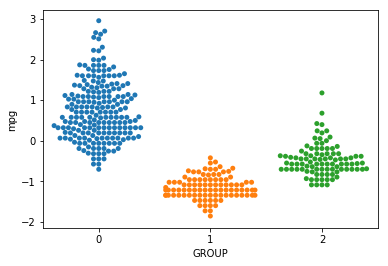

In [30]:
sns.swarmplot(df_z.GROUP,df_z.mpg)

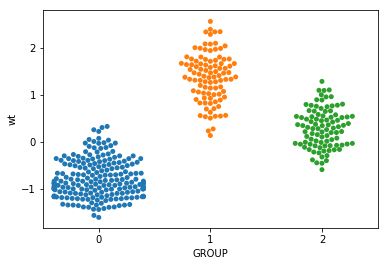

In [31]:
sns.swarmplot(df_z.GROUP,df_z.wt)

# Conclusion

The above plot's gives a clear picture of the 3 different clusters being distributed across mpg and wt values of the vehicle's.

Upon analysing both the plots we can conclude that the clusters are defining the vehicle types:

Group 0 having higher miles_per_gallon values and lower weight values, could be brought under Hatchback vehicle type

Group 1 having lower miles_per_gallon values and higher weight values, could be brought under SUV vehicle type

Group 2 having average miles_per_gallon values and average weight values, could be brought under Sedan vehicle type